In [1]:
import os
import time
from IPython import display

import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torch.utils import data
import matplotlib.pyplot as plt
import lpips


Debug Code
```
def debug(self,X):
        print('---------------1--------------')
        X1 = self.layer1(X)
        print(self.layer1.__class__.__name__, "output shape: \t", X1.shape)
        print('---------------2--------------')
        X2 = self.layer2(X1)
        print(self.layer2.__class__.__name__, "output shape: \t", X2.shape)
        print('----------------3-------------')
        X3 = self.layer3(X2)
        print(self.layer3.__class__.__name__, "output shape: \t", X3.shape)
        print('---------------4--------------')
        X4 = self.layer4(X3)
        print(self.layer4.__class__.__name__, "output shape: \t", X4.shape)
        print('----------------5-------------')
        X5 = self.layer5(X4)
        print(self.layer5.__class__.__name__, "output shape: \t", X5.shape)
        print('----------------6-------------')
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=4)
        X6 = self.layer6(X5_with_upscale)  
        print(self.layer6.__class__.__name__, "output shape: \t", X6.shape)
        print('-----------------7------------')
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=16)
        X7 = self.layer7(X6_with_upscale)  
        print(self.layer7.__class__.__name__, "output shape: \t", X7.shape)
        print('-----------------8------------')
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=40)
        X8 = self.layer8(X7_with_upscale)  
        print(self.layer8.__class__.__name__, "output shape: \t", X8.shape)
        print('-----------------9------------')
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=88)
        X9 = self.layer9(X8_with_upscale)  
        print(self.layer9.__class__.__name__, "output shape: \t", X9.shape)
        return X9
```
Experimental code
```
# input = torch.randn(1, 16, 12, 12)
# downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
# upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
# h = downsample(input)
# print(h.size())
# torch.Size([1, 16, 6, 6])
# output = upsample(h, output_size=input.size())
# print(output.size())

input = torch.randn(1, 512, 64, 64)
downsample = nn.Sequential(
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(512,1024,kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(1024,1024,kernel_size=3),
    nn.ReLU()
)
upsample = nn.Sequential(
    nn.ConvTranspose2d(1024, 512, 2,stride=2)
)
h = downsample(input)
print(h.size())
output = upsample(h)
# output = upsample(h, output_size=(-1,512,32,32))
print(output.size())
```

In [ ]:
class UNetModel(nn.Module):

    def __init__(self,output_channels=3):
        super().__init__()
        self.layer1 = self.defineFirstLayer()
        self.layer2 = self.defineSecondLayer()
        self.layer3 = self.defineThirdLayer()
        self.layer4 = self.defineFourthLayer()
        self.layer5 = self.defineFifthLayer()
        self.upCov1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.layer6 = self.defineSixthLayer()
        self.upCov2 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.layer7 = self.defineSeventhLayer()
        self.upCov3 = nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
        self.layer8 = self.defineEighthLayer()
        self.upCov4 = nn.ConvTranspose2d(16,8,kernel_size=2,stride=2)
        self.layer9 = self.defineNinthLayer(output_channels)
    
    def defineFirstLayer(self):
        return nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU()
        )
    
    def defineSecondLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(8,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineThirdLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(16,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFourthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFifthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )

    def defineSixthLayer(self):
        return nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    
    def defineSeventhLayer(self):
        return nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineEighthLayer(self):
        return nn.Sequential(
            nn.Conv2d(32,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineNinthLayer(self,output_channels):
        return nn.Sequential(
            nn.Conv2d(16,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,output_channels,kernel_size=1)
        )
    
    def crop_and_cat(self,cropTensor,catTensor,crop_by=(4,4)):
        cropTensor = self.crop(cropTensor,crop_by)
        # print(cropTensor.shape)
        # print(catTensor.shape)
        return torch.cat((cropTensor, catTensor),dim=1)


    def crop(self,cropTensor,crop_by):
        # print(crop_by)
        match crop_by:
            case (16,17):
                return cropTensor[:,:,crop_by[0]:-crop_by[0]-1,crop_by[1]:-crop_by[1]+1] 
            case _:
                return cropTensor[:,:,crop_by[0]:-crop_by[0],crop_by[1]:-crop_by[1]]
    
    def forward(self,X):
        X1 = self.layer1(X)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=(4,4))
        X6 = self.layer6(X5_with_upscale)  
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=(16,17))
        X7 = self.layer7(X6_with_upscale)  
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=(41,41))
        X8 = self.layer8(X7_with_upscale)  
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=(90,90))
        X9 = self.layer9(X8_with_upscale)  
        return X9

model = UNetModel(output_channels=3)
X = torch.rand(size=(1, 3, 256, 256), dtype=torch.float32)
model(X).shape

torch.Size([1, 3, 68, 68])

In [ ]:
def load_dataset(batch_size, resize=None):
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  train = torchvision.datasets.CelebA(root="../data", split='train', transform=trans, download=True)
  test = torchvision.datasets.CelebA(root="../data", split='test', transform=trans, download=True)
  return (
    data.DataLoader(train, batch_size, shuffle=True, num_workers=4),
    data.DataLoader(test, batch_size, shuffle=False, num_workers=4)
  )
batch_size = 1000
train_iter, test_iter = load_dataset(batch_size=batch_size,resize=(256,256))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# import random

# x_resize = torchvision.transforms.Resize((68,68))
# i=0
# for images,labels in train_iter: 
#     index = random.randint(0,batch_size-1)
#     img = x_resize(images[index])
    # plt.subplot(3, 3, i + 1)
    # plt.xticks([])
    # plt.yticks([])
    # plt.grid(False)
    # plt.imshow(img.permute(1,2,0))
    # plt.title(labels[index])
#     i += 1
#     if i >= 1:
#        break
# plt.show()

In [ ]:
import numpy as np


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  """Set the axes for matlabplots."""
  axes.set_xlabel(xlabel)
  axes.set_ylabel(ylabel)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_xscale(xscale)
  axes.set_yscale(yscale)
  if legend:
    axes.legend(legend)
  axes.grid()

class Animator:
  """For plotting data in animation"""

  def __init__(
      self,
      xlabel=None,
      ylabel=None,
      legend=None,
      xlim=None,
      ylim=None,
      xscale="linear",
      yscale="linear",
      fmts=("-", "m--", "g-", "r:"),
      nrows=1,
      ncols=1,
      figsize=(3.5, 2.5),
  ):
      #Incrementally plot multiple lines
      if legend is None:
          legend = []
      display.set_matplotlib_formats("svg")
      self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
      if nrows*ncols == 1:
        self.axes = [
            self.axes,
        ]
      #Use lamda function to capture arguments
      self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
      self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]

    for i ,(a,b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

class Timer:
  """Record multiple running times."""
  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Returns the average time"""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Returns the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumulated time."""
    return np.array(self.times).cumsum().tolist()

class Accumulator:
  """For accumulating sums over `n` variables."""

  def __init__(self, n):
    self.data = [0.0] * n

  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

def try_gpu(i=0):
  """Return gpu(i) if exists, otherwise return cpu()."""
  if torch.cuda.device_count() >= i+1:
    return torch.device(f"cuda:{i}")
  return torch.device("cpu")

In [ ]:
# We compute classification accuracy on the current batch
# and add this metric to the accumulator, for plotting purposes
x_resize_test = torchvision.transforms.Resize((68,68))
loss_test = nn.MSELoss()
def accuracy(y_hat, y):
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = torch.argmax(y_hat, axis=1)
  cmp_ = y_hat.type(y.dtype) == y
  return float(cmp_.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
  """Compute the accuracy of the model on the dataset using GPU"""
  if isinstance(net, torch.nn.Module):
    net.eval() # Set the model to evaluation mode
    if not device:
      device = next(iter(net.parameters())).device
  # No. of correct predictions, no. of predictions
  # metric = Accumulator(2)
  for X, y in data_iter:
    X = X.to(device)
    y = y.to(device)
    acc = loss_test(net(X), x_resize_test(X))
  return acc


In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, filename, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print("training on", device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = lpips.LPIPS(net='vgg')
  x_resize = torchvision.transforms.Resize((68,68))
  timer, num_batches = Timer(), len(train_iter)
  animator = Animator(xlabel="epoch", xlim=[1, num_epochs*num_batches], ylim=[0,1], legend = ["train loss"])
  if os.path.isfile(filename):
    net = torch.load(filename)
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no of examples
    # metric = Accumulator(1)
    net.train()
    for i, (X,_) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X = X.to(device)
      y_hat = net(X)
      y = x_resize(X)
      l = loss.forward(y_hat,y)
      optimizer.step()
      with torch.no_grad():
        mean = torch.sum(l)/X.shape[0]
        # print(f'epoch : {epoch}, batch per epoch : {i}, X : {epoch*num_batches + (i + 1)}, Y : {mean}')
        animator.add(epoch*num_batches + (i + 1), (mean, None))
      if i > num_batches:
        break
      if i%2 == 0:
        torch.save(net, filename)
        # metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      # timer.stop()
      # train_l = metric[0] / metric[2]
      # train_acc = metric[1] / metric[2]
      # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
      
    #   print(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    # test_acc = evaluate_accuracy_gpu(net, test_iter)
    # animator.add(epoch + 1, (None, test_acc))
  #   print(epoch + 1, (None, None, test_acc))
  # print(f"loss {train_l:.3f}, train_acc:{train_acc:.3f}, " f"test acc {test_acc:.3f}")
  # print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")

KeyboardInterrupt: 

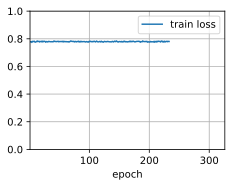

In [8]:
lr, num_epochs = 0.9, 2
file_name = './unet_small_parameters_vgg.pt'
train(model, train_iter, test_iter, num_epochs, lr, file_name, try_gpu())

Python(11099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(11102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


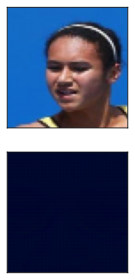

In [9]:
import random
model = torch.load('./unet_small_parameters_vgg.pt')
model.eval()
for i,(X,_) in enumerate(test_iter):
    if i>=1:
        break
    index = random.randint(0,X.shape[0])
    image = X[index]
    model_input = torch.unsqueeze(image,dim=0)
    with torch.no_grad():
        result = model(model_input)[0]
        plt.subplot(2, 1, 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_resize_test(image).permute(1,2,0))
        plt.subplot(2, 1, 2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result.permute(1,2,0))
    
plt.show()
